In [ ]:
import numpy as np
from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance


def is_sorted_ascending(arr):
    return np.all(np.diff(arr) >= 0)

In [ ]:
def samples_to_empirical_distributions(samples, num_classes):
    num_timesteps, num_samples = samples.shape
    S = np.zeros((num_timesteps, num_classes))
    
    for t in range(num_timesteps):
        counts = np.bincount(samples[t], minlength=num_classes)
        S[t] = counts / np.sum(counts)
        
    return S

In [67]:
def process_samples_from_matrix(dataset, S, num_timesteps):
    emd_matrix = np.zeros((num_timesteps, num_timesteps))
    
    for i in range(num_timesteps):
        for j in range(num_timesteps):
            emd_matrix[i, j] = wasserstein_distance(S[i], S[j])
            
    mean_emd = np.mean(emd_matrix[np.triu_indices(num_timesteps, k=1)])
    median_emd = np.median(emd_matrix[np.triu_indices(num_timesteps, k=1)])
    std_emd = np.std(emd_matrix[np.triu_indices(num_timesteps, k=1)])
    
    return dataset, emd_matrix, mean_emd, median_emd, std_emd

def plot_emd_heatmaps(results):
    num_processes = len(results)
    num_rows = (num_processes + 1) // 2  # Round up to ensure all plots fit
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()  # Flatten the 2D array to easily iterate
    
    for i in range(num_processes):
        dataset, emd_matrix, mean_emd, median_emd, std_emd = results[i]
        sns.heatmap(emd_matrix, cmap='viridis', annot=False, ax=axes[i])
        axes[i].set_title(f"$W_1$: {dataset} (Mean: {mean_emd:.2e}, std: {std_emd:.2e})")
    
    # Hide any unused subplots
    for i in range(num_processes, num_rows * 2):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

In [70]:
num_buckets = 100

results = []

for name in ['tgbl-wiki', 'tgbl-review', 'tgbl-comment', 'tgbl-coin']:

    dataset = PyGLinkPropPredDataset(name=name, root="datasets")
    train_mask = dataset.train_mask

    data = dataset.get_TemporalData()
    train_dst = data.dst[train_mask]
    train_t = data.t[train_mask]

    if not is_sorted_ascending(train_t):
        print("Sorting train data")
        sort_ix = np.argsort(train_t)
        train_dst = train_dst[sort_ix]
        train_t = train_t[sort_ix]


    num_classes = train_dst.max()+1    
    bucket_size = train_dst.shape[0] // num_buckets
    samples = train_dst[:num_buckets * bucket_size].reshape(num_buckets, bucket_size)

    empiricals = samples_to_empirical_distributions(samples, num_classes)

    results.append(process_samples_from_matrix(name, empiricals, num_buckets, num_classes))

raw file found, skipping download
Dataset directory is  /home/jdabrowski/miniconda3/lib/python3.10/site-packages/tgb/datasets/tgbl_wiki
loading processed file
raw file found, skipping download
Dataset directory is  /home/jdabrowski/miniconda3/lib/python3.10/site-packages/tgb/datasets/tgbl_review
loading processed file
raw file found, skipping download
Dataset directory is  /home/jdabrowski/miniconda3/lib/python3.10/site-packages/tgb/datasets/tgbl_comment
loading processed file
raw file found, skipping download
Dataset directory is  /home/jdabrowski/miniconda3/lib/python3.10/site-packages/tgb/datasets/tgbl_coin
loading processed file
Sorting train data
raw file found, skipping download
Dataset directory is  /home/jdabrowski/miniconda3/lib/python3.10/site-packages/tgb/datasets/tgbl_flight
loading processed file
Sorting train data


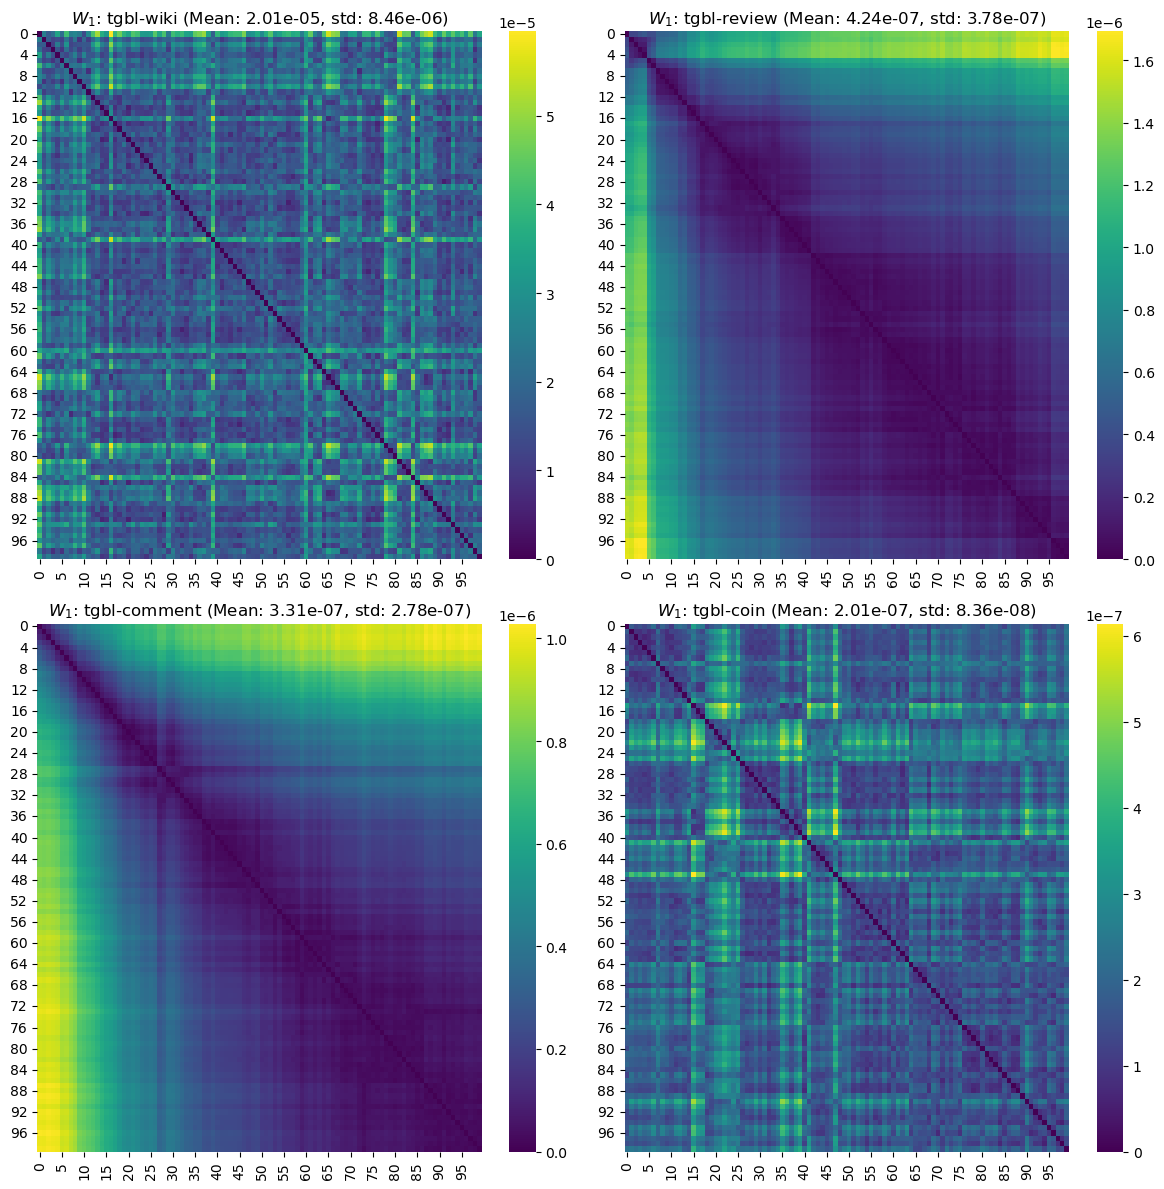

In [71]:
plot_emd_heatmaps(results)

In [64]:
def plot_sequential(num_buckets=50, datasets=['tgbl-wiki', 'tgbl-review', 'tgbl-comment', 'tgbl-coin']):

    results = []

    for name in datasets:

        dataset = PyGLinkPropPredDataset(name=name, root="datasets")
        train_mask = dataset.train_mask
        # val_mask = dataset.val_mask

        data = dataset.get_TemporalData()
        # train_src = data.src[train_mask]
        train_dst = data.dst[train_mask]
        train_t = data.t[train_mask]

        if not is_sorted_ascending(train_t):
            print("Sorting train data")
            sort_ix = np.argsort(train_t)
            train_dst = train_dst[sort_ix]
            train_t = train_t[sort_ix]


        num_classes = train_dst.max()+1    
        bucket_size = train_dst.shape[0] // num_buckets
        samples = train_dst[:num_buckets * bucket_size].reshape(num_buckets, bucket_size)
        empiricals = samples_to_empirical_distributions(samples, num_classes)

        results.append((name, empiricals))

    def process_and_plot_sequential_emd_multiple(S_list, num_timesteps):
        num_processes = len(S_list)
        mean_sequential_emds = []
        std_sequential_emds = []
        
        plt.figure(figsize=(10, 6))
        
        markers_cycle = ['.', '+', 'x', '^', '*']

        for i in range(num_processes):
            title, S = S_list[i]
            
            sequential_emd = np.zeros(num_timesteps - 1)
            for j in range(num_timesteps - 1):
                sequential_emd[j] = wasserstein_distance(S[j], S[j + 1])
                
            mean_sequential_emd = np.mean(sequential_emd)
            std_sequential_emd = np.std(sequential_emd)
            mean_sequential_emds.append(mean_sequential_emd)
            std_sequential_emds.append(mean_sequential_emd)
            
            plt.plot(range(num_timesteps - 1), sequential_emd, marker=markers_cycle[i % len(markers_cycle)], label=f"{title} (Mean $W_1$: {mean_sequential_emd:.2e}, Std $W_1$: {std_sequential_emd:.2e})")
            
        plt.yscale('log')
        plt.title("Sequential $W_1 (T_{i}, T_{i+1})$" + f" with {num_timesteps} temporal buckets.")
        plt.xlabel("$T_{i}$")
        plt.ylabel("$W_1 (T_{i}, T_{i+1})$ logscale")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
        plt.show()

    process_and_plot_sequential_emd_multiple(results, num_buckets)

raw file found, skipping download
Dataset directory is  /home/jdabrowski/miniconda3/lib/python3.10/site-packages/tgb/datasets/tgbl_wiki
loading processed file
raw file found, skipping download
Dataset directory is  /home/jdabrowski/miniconda3/lib/python3.10/site-packages/tgb/datasets/tgbl_review
loading processed file
raw file found, skipping download
Dataset directory is  /home/jdabrowski/miniconda3/lib/python3.10/site-packages/tgb/datasets/tgbl_comment
loading processed file
raw file found, skipping download
Dataset directory is  /home/jdabrowski/miniconda3/lib/python3.10/site-packages/tgb/datasets/tgbl_coin
loading processed file
Sorting train data


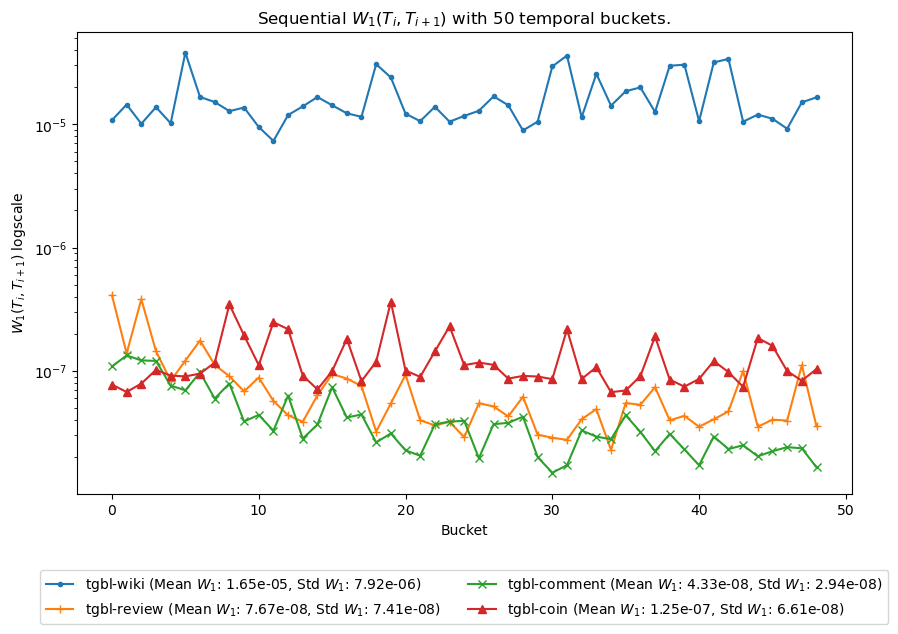

In [65]:
plot_sequential(50)